# 🌐 Réseaux de neuronnes convolutifs 🌐

Dans ce notebook, nous testons des **réseaux de neurones convolutifs** pour la classification en utilisant la bibliothèque **Keras**. Nous nous appuyons sur des plongements pré-entraînés construits avec FastText et entraînons le modèle avec **validation croisée** sur les descriptions **sans mots outils**. Une fois le nombre adéquat d'époques déterminé, nous ré-entraînons le modèle sur l'ensemble des données d'entraînement (colonne : description) et testons sur les trois colonnes de notre jeu de données test.

In [103]:
import numpy as np
import pandas as pd
from sklearn import model_selection
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import Embedding
from tensorflow.keras import layers
import seaborn as sns
sns.set_theme(style="darkgrid")
import matplotlib.pyplot as plt

## Chargement des données

In [63]:
# Création du dossier data
!mkdir data
# Téléchargement des fichiers train et test dans le dossier data
!wget -P data https://raw.githubusercontent.com/tpazakou/projet_apprentissage_automatique/refs/heads/main/data/test.csv
!wget -P data https://raw.githubusercontent.com/tpazakou/projet_apprentissage_automatique/refs/heads/main/data/train.csv

mkdir: cannot create directory ‘data’: File exists
--2024-12-10 14:34:46--  https://raw.githubusercontent.com/tpazakou/projet_apprentissage_automatique/refs/heads/main/data/test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 289798 (283K) [text/plain]
Saving to: ‘data/test.csv.1’

test.csv.1          100%[===================>] 283.01K  --.-KB/s    in 0.02s   

2024-12-10 14:34:46 (11.9 MB/s) - ‘data/test.csv.1’ saved [289798/289798]

--2024-12-10 14:34:47--  https://raw.githubusercontent.com/tpazakou/projet_apprentissage_automatique/refs/heads/main/data/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185

In [64]:
dtypes = dtype= {'label_fr': 'category',
                 'description': 'object',
                 'description_tokens': 'object',
                 'description_wosw': 'object',
                 'description_lemmas': 'object',
                 'simple': 'object',
                 'simple_tokens': 'object',
                 'simple_wosw': 'object',
                 'simple_lemmas': 'object',
                 'fautes': 'object',
                 'fautes_tokens': 'object',
                 'fautes_wosw': 'object',
                 'fautes_lemmas': 'object'}

In [65]:
train_df = pd.read_csv("data/train.csv", sep = ",", index_col=False, dtype=dtypes)
test_df = pd.read_csv("data/test.csv", sep = ",", index_col=False, dtype=dtypes)

## Préparation des données

In [66]:
# Liste des classes dans le jeu de données
class_names = sorted(train_df.label_fr.unique().categories.to_list())
print("Classes :", class_names)

Classes : ['acné', 'allergie', 'arthrite', 'asthme bronchique', 'dengue', 'diabète', 'hypertension', 'impétigo', 'infection fongique', 'jaunisse', 'migraine', 'paludisme', 'pneumonie', 'psoriasis', 'rhume', 'réaction médicamenteuse', 'spondylose cervicale', 'typhoïde', 'ulcère gastroduodénal', 'varicelle', 'varices']


In [67]:
# Attribution d'un identifiant numérique à chaque classe
class_index = {class_names[i]:i for i in range(len(class_names))}
class_index

{'acné': 0,
 'allergie': 1,
 'arthrite': 2,
 'asthme bronchique': 3,
 'dengue': 4,
 'diabète': 5,
 'hypertension': 6,
 'impétigo': 7,
 'infection fongique': 8,
 'jaunisse': 9,
 'migraine': 10,
 'paludisme': 11,
 'pneumonie': 12,
 'psoriasis': 13,
 'rhume': 14,
 'réaction médicamenteuse': 15,
 'spondylose cervicale': 16,
 'typhoïde': 17,
 'ulcère gastroduodénal': 18,
 'varicelle': 19,
 'varices': 20}

In [68]:
# Entraînement sur la colonne description sans mots outils
# Les noms des classes sont remplacés par leur identifiant

X_train = train_df.description_wosw
y_train = train_df.label_fr.map(class_index)

In [69]:
X_train.head()

,description_wosw
0,beaucoup ballonnements constipation vraiment d...
1,perds cheveux texture cheveux beaucoup changé ...
2,développé éruption cutanée couvre corps accomp...
3,sens extrêmement épuisé toux persistante mal r...
4,fièvre sens nauséeux étourdi cœur fort esprit ...


In [70]:
y_train.head()

,label_fr
0,17
1,15
2,4
3,3
4,15


## Indexation du vocabulaire

In [71]:
# max_voc_size : vocabulaire limité aux 20 000 mots les plus fréquents car les CNN ont besoin d'une longueur limitée
# max_seq_length : fenêtres de 50 mots
def get_vectorizer(documents, max_voc_size=20000, max_seq_length=50, batch_size=128):
  vectorizer = TextVectorization(max_tokens=max_voc_size,
                                 output_sequence_length=max_seq_length)
  # jeu de données :
  text_ds = tf.data.Dataset.from_tensor_slices(documents).batch(batch_size)
  # vocabulaire :
  vectorizer.adapt(text_ds)
  return vectorizer

In [72]:
# obtenir le vocabulaire
# les descriptions étant courtes et sans mots outils, le vocabulaire est beaucoup plus restreint que le maximum de 20 000 mots
keras_vectorizer = get_vectorizer(X_train)
voc = keras_vectorizer.get_vocabulary()
print(len(voc))

1037


In [73]:
# association d'un identifiant unique à chaque item du vocabulaire
word_index = dict(zip(voc, range(len(voc))))

## Chargement des plongements pré-entraînés

Les plongements, qui ont une taille de 300, sont obtenus à partir de CommonCrawl et Wikipedia en français et ils sont construits avec l'algorithme fastText (disponible sur : https://git.unistra.fr/dbernhard/ftaa_data/-/blob/main/README.md)

In [74]:
!wget -P data https://git.unistra.fr/dbernhard/ftaa_data/-/raw/main/cc.fr.300.txt.zip
!unzip -q data/cc.fr.300.txt.zip -d data

--2024-12-10 14:34:48--  https://git.unistra.fr/dbernhard/ftaa_data/-/raw/main/cc.fr.300.txt.zip
Resolving git.unistra.fr (git.unistra.fr)... 130.79.254.48
Connecting to git.unistra.fr (git.unistra.fr)|130.79.254.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10954038 (10M) [application/octet-stream]
Saving to: ‘data/cc.fr.300.txt.zip.1’

cc.fr.300.txt.zip.1 100%[===================>]  10.45M  6.60MB/s    in 1.6s    

2024-12-10 14:34:50 (6.60 MB/s) - ‘data/cc.fr.300.txt.zip.1’ saved [10954038/10954038]

replace data/cc.fr.300.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [75]:
# dictionnaire pour associer chaque mot à sa représentation vectorielle

def load_embeddings(embeddings_file):
  embeddings_index = {}
  with open(embeddings_file, 'r', encoding='utf8') as f:
      for line in f:
          word, coefs = line.split(maxsplit=1)
          coefs = np.fromstring(coefs, "f", sep=" ")
          embeddings_index[word] = coefs
  print(f'{len(embeddings_index)} vecteurs de mots ont été lus')
  return embeddings_index

In [76]:
cc_fr_embeddings = load_embeddings('data/cc.fr.300.txt')

18653 vecteurs de mots ont été lus


In [77]:
# matrice de plongements
# la ligne i correspond au plongement du mot d'indice i dans le vocabulaire
# mots sans plongement correspondant : vecteurs de 0

def get_embedding_matrix(vocabulary, embeddings_index, embedding_dim = 300):
  num_tokens = len(vocabulary)
  hits = 0
  misses = 0

  embedding_matrix = np.zeros((num_tokens, embedding_dim))
  for word, i in word_index.items():
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          embedding_matrix[i] = embedding_vector
          hits += 1
      else:
          misses += 1
  print(f'{hits} mots ont été trouvés dans les plongements pré-entraînés')
  print(f'{misses} sont absents')
  return embedding_matrix

In [78]:
# construction de la matrice
cc_fr_embedding_matrix = get_embedding_matrix(voc, cc_fr_embeddings)

785 mots ont été trouvés dans les plongements pré-entraînés
252 sont absents


In [79]:
# matrice de 1037 lignes (longueur du vocabulaire) et 300 colonnes (longueur des plongements)
cc_fr_embedding_matrix.shape

(1037, 300)

## Construction et entraînement du modèle avec validation croisée à 5 plis

In [80]:
# Création du modèle
def get_CNN_model(voc_size, embedding_matrix, embedding_dim=300):
  # trainable = True : les plongements evoluent au cours de l'apprentissage
  int_sequences_input = keras.Input(shape=(None,), dtype="int64")
  embedding_layer = Embedding(voc_size, embedding_dim, trainable=True,
      embeddings_initializer=keras.initializers.Constant(embedding_matrix),
  )

  embedded_sequences = embedding_layer(int_sequences_input)
  x = layers.Conv1D(64, 5, activation="relu")(embedded_sequences)
  x = layers.MaxPooling1D(5)(x)
  x = layers.Conv1D(64, 5, activation="relu")(x)
  x = layers.GlobalMaxPooling1D()(x)
  x = layers.Dense(64, activation="relu")(x)
  x = layers.Dropout(0.5)(x)
  preds = layers.Dense(len(class_names), activation="softmax")(x)
  model = keras.Model(int_sequences_input, preds)
  return model

In [81]:
# Architecture du modèle
cc_fr_model = get_CNN_model(len(voc), cc_fr_embedding_matrix)
cc_fr_model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)          │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_13 (Embedding)             │ (None, None, 300)           │         311,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_26 (Conv1D)                   │ (None, None, 64)            │          96,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_13 (MaxPooling1D)      │ (None, None, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_27 (Conv1D)                   │ (None, None, 64)            │          20,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_13              │ (None, 64)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 21)                  │           1,365 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 433,233 (1.65 MB)

 Trainable params: 433,233 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

In [82]:
# Fonction pour l'entraînement du modèle avec validation croisée

def train_model(X, y, model_function, vectorizer,
                voc_size, embedding_matrix, embedding_dim=300, batch_size=128):
  # Listes pour sauvegarder les résultats obtenus à chaque pli
  acc_per_fold = []
  loss_per_fold = []
  histories = []
  folds = 5
  stratkfold = model_selection.StratifiedKFold(n_splits=folds, shuffle=True,
                                              random_state=12)
  fold_no = 1
  for train, test in stratkfold.split(X, y):
    m_function = globals()[model_function]
    model = m_function(voc_size, embedding_matrix, embedding_dim)

    print('------------------------------------------------------------------------')
    print(f'Entraînement pour le pli {fold_no} ...')
    fold_x_train = vectorizer(X.iloc[train].to_numpy()).numpy()
    fold_x_val = vectorizer(X.iloc[test].to_numpy()).numpy()
    fold_y_train = y.iloc[train].to_numpy()
    fold_y_val = y.iloc[test].to_numpy()

    model.compile(
      loss="sparse_categorical_crossentropy", optimizer="adam", metrics=[keras.metrics.SparseCategoricalAccuracy()]
    )
    # Entraînement
    history = model.fit(fold_x_train, fold_y_train, batch_size=batch_size,
                        epochs=30, validation_data=(fold_x_val, fold_y_val))
    histories.append(history)
    # Evaluation sur les données de validation
    scores = model.evaluate(fold_x_val, fold_y_val, verbose=0)
    print(f'Scores pour le pli {fold_no}: {model.metrics_names[0]} = {scores[0]:.2f};',
          f'{model.metrics_names[1]} = {scores[1]*100:.2f}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    fold_no = fold_no + 1

  # Affichage des scores moyens par pli
  print('---------------------------------------------------------------------')
  print('Scores par pli')
  for i in range(0, len(acc_per_fold)):
    print('---------------------------------------------------------------------')
    print(f'> Pli {i+1} - Loss: {loss_per_fold[i]:.2f}',
          f'- Accuracy: {acc_per_fold[i]:.2f}%')
  print('---------------------------------------------------------------------')
  print('Scores moyens pour tous les plis :')
  print(f'> Accuracy: {np.mean(acc_per_fold):.2f}',
        f'(+- {np.std(acc_per_fold):.2f})')
  print(f'> Loss: {np.mean(loss_per_fold):.2f}')
  print('---------------------------------------------------------------------')
  return histories

In [83]:
# Entraînement du modèle

CNN_histories = train_model(X_train, y_train, 'get_CNN_model',
                            keras_vectorizer, len(voc), cc_fr_embedding_matrix)

------------------------------------------------------------------------
Entraînement pour le pli 1 ...
Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 192ms/step - loss: 3.0393 - sparse_categorical_accuracy: 0.0337 - val_loss: 3.0202 - val_sparse_categorical_accuracy: 0.0984
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - loss: 3.0026 - sparse_categorical_accuracy: 0.1257 - val_loss: 2.9905 - val_sparse_categorical_accuracy: 0.2295
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - loss: 2.9646 - sparse_categorical_accuracy: 0.1475 - val_loss: 2.9462 - val_sparse_categorical_accuracy: 0.1803
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step - loss: 2.8877 - sparse_categorical_accuracy: 0.1887 - val_loss: 2.8840 - val_sparse_categorical_accuracy: 0.2295
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step - loss: 2.8205 - sparse_categorical_accuracy: 0.1590 - val_loss: 2.8010 - val_sparse_categorical_accuracy: 0.2295
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - loss: 2.7354 - sparse_ca

## Analyse des résultats

In [84]:
def plot_results(histories):
  accuracy_data = []
  loss_data = []
  for i, h in enumerate(histories):
    acc = h.history['sparse_categorical_accuracy']
    val_acc = h.history['val_sparse_categorical_accuracy']
    loss = h.history['loss']
    val_loss = h.history['val_loss']
    for j in range(len(acc)):
      accuracy_data.append([i+1, j+1, acc[j], 'Entraînement'])
      accuracy_data.append([i+1, j+1, val_acc[j], 'Validation'])
      loss_data.append([i+1, j+1, loss[j], 'Entraînement'])
      loss_data.append([i+1, j+1, val_loss[j], 'Validation'])

  acc_df = pd.DataFrame(accuracy_data,
                        columns=['Pli', 'Epoch', 'Accuracy', 'Données'])
  sns.relplot(data=acc_df, x='Epoch', y='Accuracy', hue='Pli', style='Données',
              kind='line')

  loss_df = pd.DataFrame(loss_data, columns=['Pli', 'Epoch', 'Perte', 'Données'])
  sns.relplot(data=loss_df, x='Epoch', y='Perte', hue='Pli', style='Données',
              kind='line')

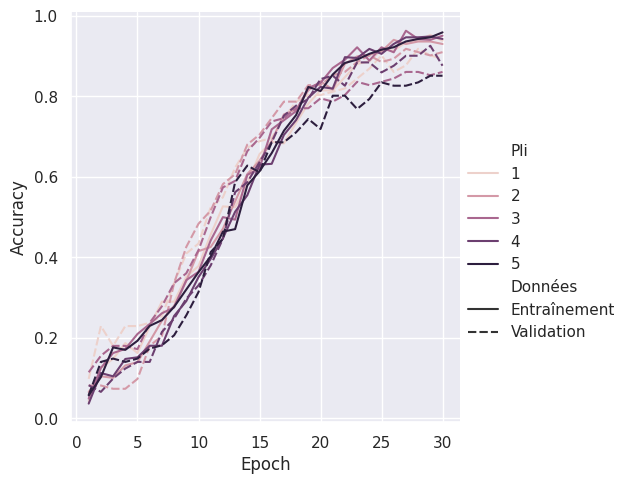

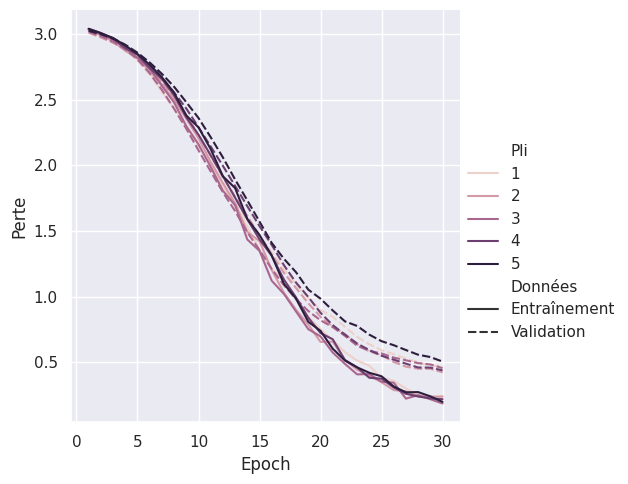

In [85]:
plot_results(CNN_histories)

🔎 Pour les données d'entraînement et de validation, la perte diminue à chaque époque, tandis que la justesse augmente. Certes, le rythme de progression diffère entre les données de validation et celles d'entraînement, mais il n'y a pas de très grandes différences entre les deux lignes. Les résultats semblent se stabiliser vers la 25ᵉ époque : la justesse n'augmente plus de manière significative, et la pente de la perte commence à s'aplatir. Nous ne tentons pas un nouvel apprentissage avec davantage d'époques, car, étant donné la tendance des pentes à s'aplatir, cela pourrait conduire à un surajustement du modèle.

## Entraînement sur l'ensemble des données

Après avoir obtenu des résultats satisfaisants, nous ré-entraînons le modèle sur l'ensemble des données d'entraînement (colonne `description_wosw`, sans validation croisée) et le testons également sur les deux autres colonnes de notre jeu de données de **test**, toujours sans mots outils.

**Test sur la colonne <u>description</u> :**

In [94]:
X_test = test_df.description_wosw
y_test = test_df.label_fr.map(class_index)

In [95]:
def train_model(X_train, X_test, y_train, y_test, model_function, vectorizer,
                voc_size, embedding_matrix, embedding_dim=300, batch_size=128):

  m_function = globals()[model_function]
  model = m_function(voc_size, embedding_matrix, embedding_dim)

  print('------------------------------------------------------------------------')
  print('Entraînement du modèle ...')

  # Vectorisation
  x_train = vectorizer(X_train.to_numpy()).numpy()
  x_test = vectorizer(X_test.to_numpy()).numpy()

  y_train = y_train.to_numpy()
  y_test = y_test.to_numpy()

  # Compilation du modèle
  model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
  )

  # Entraînement
  history = model.fit(x_train, y_train, batch_size=batch_size,
                      epochs=30, validation_data=(x_test, y_test))

  # Évaluation
  scores = model.evaluate(x_test, y_test, verbose=0)
  print(f'Scores: {model.metrics_names[0]} = {scores[0]:.2f}; {model.metrics_names[1]} = {scores[1]*100:.2f}%')

  print('---------------------------------------------------------------------')
  print('Score final sur les données de test :')
  print(f'> Accuracy: {scores[1]*100:.2f}%')
  print(f'> Loss: {scores[0]:.2f}')
  print('---------------------------------------------------------------------')

  return history

In [96]:
CNN_histories = train_model(X_train, X_test, y_train, y_test, 'get_CNN_model',
                            keras_vectorizer, len(voc), cc_fr_embedding_matrix)

------------------------------------------------------------------------
Entraînement du modèle ...
Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step - loss: 3.0438 - sparse_categorical_accuracy: 0.0529 - val_loss: 3.0274 - val_sparse_categorical_accuracy: 0.0789
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - loss: 2.9975 - sparse_categorical_accuracy: 0.1120 - val_loss: 2.9985 - val_sparse_categorical_accuracy: 0.0724
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step - loss: 2.9359 - sparse_categorical_accuracy: 0.1333 - val_loss: 2.9518 - val_sparse_categorical_accuracy: 0.0724
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - loss: 2.8584 - sparse_categorical_accuracy: 0.1641 - val_loss: 2.8810 - val_sparse_categorical_accuracy: 0.1184
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - loss: 2.7441 - sparse_categorical_accuracy: 0.1988 - val_loss: 2.7799 - val_sparse_categorical_accuracy: 0.1974
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - loss: 2.6255 - sparse_catego

**Test sur les descriptions <u>simples</u>** :

In [97]:
X_test = test_df.simple_wosw

In [98]:
CNN_histories_simple = train_model(X_train, X_test, y_train, y_test, 'get_CNN_model',
                            keras_vectorizer, len(voc), cc_fr_embedding_matrix)

------------------------------------------------------------------------
Entraînement du modèle ...
Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - loss: 3.0368 - sparse_categorical_accuracy: 0.0665 - val_loss: 3.0214 - val_sparse_categorical_accuracy: 0.0789
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - loss: 2.9886 - sparse_categorical_accuracy: 0.0852 - val_loss: 2.9928 - val_sparse_categorical_accuracy: 0.0921
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 2.9300 - sparse_categorical_accuracy: 0.1226 - val_loss: 2.9489 - val_sparse_categorical_accuracy: 0.1118
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - loss: 2.8378 - sparse_categorical_accuracy: 0.1675 - val_loss: 2.8916 - val_sparse_categorical_accuracy: 0.1250
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - loss: 2.7363 - sparse_categorical_accuracy: 0.1970 - val_loss: 2.8184 - val_sparse_categorical_accuracy: 0.1316
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - loss: 2.6039 - sparse_catego

**Test sur les descriptions <u>avec fautes</u> :**

In [99]:
X_test = test_df.fautes_wosw

In [100]:
CNN_histories_fautes = train_model(X_train, X_test, y_train, y_test, 'get_CNN_model',
                            keras_vectorizer, len(voc), cc_fr_embedding_matrix)

------------------------------------------------------------------------
Entraînement du modèle ...
Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - loss: 3.0438 - sparse_categorical_accuracy: 0.0582 - val_loss: 3.0280 - val_sparse_categorical_accuracy: 0.0395
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - loss: 2.9926 - sparse_categorical_accuracy: 0.0853 - val_loss: 3.0071 - val_sparse_categorical_accuracy: 0.0395
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - loss: 2.9387 - sparse_categorical_accuracy: 0.1146 - val_loss: 2.9711 - val_sparse_categorical_accuracy: 0.0724
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - loss: 2.8632 - sparse_categorical_accuracy: 0.1670 - val_loss: 2.9197 - val_sparse_categorical_accuracy: 0.1316
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - loss: 2.7643 - sparse_categorical_accuracy: 0.2018 - val_loss: 2.8656 - val_sparse_categorical_accuracy: 0.1513
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - loss: 2.6098 - sparse_catego

## 🔎 Analyse des résultats

Le modèle affiche de meilleures performances sur la colonne "description" qu'auparavant, pendant la validation croisée (**91,45 %** contre **87,82 % ± 2,13**). Cela n'est pas surprenant, car il a été entraîné sur l'ensemble des données d'entraînement.

Les **performances diminuent** lorsqu'on le teste sur des **descriptions simples** ou contenant des **fautes**, ce qui suit la tendance observée avec tous les autres modèles testés. Ce modèle ne gère pas très bien non plus la variation des données, les descriptions originales étant systématiquement mieux classées.


In [101]:
results_CNN = pd.DataFrame({
    "CNN": [91.45],
    "CNN_simple": [83.55],
    "CNN_fautes": [73.68]
})

results_CNN

,CNN,CNN_simple,CNN_fautes
0,91.45,83.55,73.68


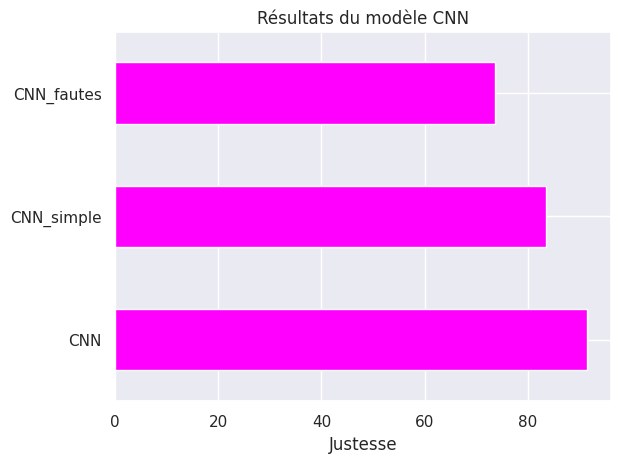

In [111]:
results_CNN.T.plot(kind="barh", color="magenta", legend=False)
plt.xlabel("Justesse")
plt.title("Résultats du modèle CNN")
plt.show()


In [112]:
!mkdir results
results_CNN.to_csv("results/results_CNN.csv", index=False)